In [2]:
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Q1. Downloading the data

We'll use the same NYC taxi dataset, but instead of "Green Taxi Trip Records", we'll use "Yellow Taxi Trip Records".

Download the data for January and February 2023.

Read the data for January. How many columns are there?

In [3]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')

In [4]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [5]:
len(df.columns)

19

### Q2. Computing duration

Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the standard deviation of the trips duration in January?

In [6]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df['duration'] = df.duration.dt.total_seconds() / 60

In [7]:
df.duration.mean()

np.float64(15.668995167330452)

In [8]:
df.duration.std()

np.float64(42.59435124195458)

### Q3. Dropping outliers

In [9]:
len(df[(df.duration >= 1) & (df.duration <= 60)]) / len(df) * 100

98.1220282212598

In [10]:
df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

### Q4. One-hot encoding

In [11]:
categorical = ['PULocationID', 'DOLocationID']

In [12]:
df[categorical] = df[categorical].astype(str)

In [13]:
train_dicts = df[categorical].to_dict(orient='records')

In [14]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [15]:
print(f'Feature matrix size: {X_train.shape}')

Feature matrix size: (3009173, 515)


### Q5. Training a model

In [16]:
target = 'duration'
y_train = df[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print(f'Train RMSE: {root_mean_squared_error(y_train, y_pred)}')

Train RMSE: 7.649261956702323


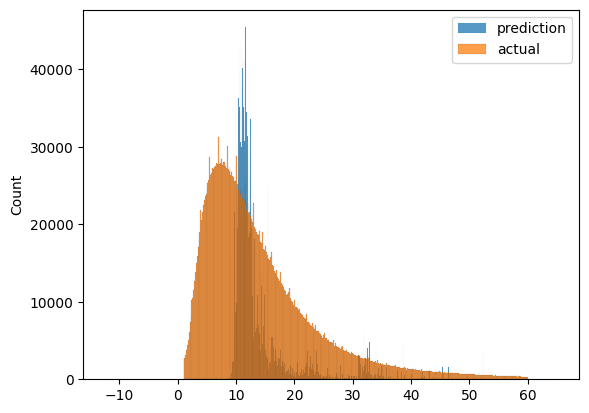

In [18]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend();

### Q6. Evaluating the model

In [19]:
categorical = ['PULocationID', 'DOLocationID']

def read_data(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].astype('str')
    
    return df

In [20]:
df_val = read_data('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [28]:
val_dicts = df_val[categorical].to_dict(orient='records')
len(val_dicts[0])

2

In [27]:
val_dicts[0]

{'PULocationID': '142', 'DOLocationID': '163'}

In [22]:
X_val = dv.transform(val_dicts) 
y_val = df_val.duration.values

In [29]:
X_val.shape, y_val.shape

((2855951, 515), (2855951,))

In [23]:
y_pred = lr.predict(X_val)

In [24]:
print(f'Val RMSE: {root_mean_squared_error(y_val, y_pred)}')

Val RMSE: 7.811815406287519
